<a href="https://colab.research.google.com/github/SikoticVinyl/VictorVis2.0/blob/aaron_halo-analytics/HaloDataDashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
# Install required packages
#!pip install pandas numpy tensorflow scikit-learn xgboost matplotlib seaborn

In [50]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Traditional ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System utilities
import warnings
warnings.filterwarnings('ignore')

In [51]:
# Create mock Halo match data
np.random.seed(42)  # For reproducibility

# Generate sample data
n_samples = 1000
mock_data = {
    'kills': np.random.randint(0, 30, n_samples),
    'deaths': np.random.randint(1, 20, n_samples),
    'assists': np.random.randint(0, 15, n_samples),
    'shots_fired': np.random.randint(50, 300, n_samples),
    'shots_hit': np.random.randint(20, 150, n_samples),
    'damage_dealt': np.random.randint(1000, 5000, n_samples)
}

# Create DataFrame
df = pd.DataFrame(mock_data)

# Add engineered features
df['kd_ratio'] = df['kills'] / df['deaths']
df['accuracy'] = df['shots_hit'] / df['shots_fired']
df['avg_damage_per_kill'] = df['damage_dealt'] / df['kills'].replace(0, 1)

# Create target variable (win/loss)
# Let's say higher KD ratio and accuracy tend to lead to wins
df['win'] = ((df['kd_ratio'] > df['kd_ratio'].median()) &
             (df['accuracy'] > df['accuracy'].median())).astype(int)

# Display sample of data
print("Sample of the dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Sample of the dataset:
   kills  deaths  assists  shots_fired  shots_hit  damage_dealt   kd_ratio  \
0      6      17       12           63         23          4191   0.352941   
1     19      14        8          170        126          2837   1.357143   
2     28       9       13          211         70          1689   3.111111   
3     14      14        5          230         69          4759   1.000000   
4     10       1       11          170         25          3949  10.000000   

   accuracy  avg_damage_per_kill  win  
0  0.365079           698.500000    0  
1  0.741176           149.315789    0  
2  0.331754            60.321429    0  
3  0.300000           339.928571    0  
4  0.147059           394.900000    0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   kills                1000 non-null   int64

In [52]:
# Prepare features and target
X = df.drop('win', axis=1)
y = df['win']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print shapes and class distribution
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True))

Training set shape: (800, 9)
Testing set shape: (200, 9)

Class distribution in training set:
win
0    0.75875
1    0.24125
Name: proportion, dtype: float64


In [53]:
# Create improved model architecture
print("Creating model architecture...")
model = Sequential([
    # Input layer
    Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],),
          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    # Hidden layers
    Dense(256, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

# Compile model with multiple metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Creating model architecture...


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 512)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,505 (709.00 KB)

 Trainable params: 179,585 (701.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [54]:
# Set up callbacks
callbacks = [
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Calculate class weights
class_weights = dict(zip(
    np.unique(y_train),
    1 / (np.bincount(y_train) / len(y_train))
))

print("Class weights:", class_weights)

Class weights: {0: 1.3179571663920921, 1: 4.145077720207254}


In [55]:
# Train the model
history = model.fit(
    X_train_scaled, y_train.values,  # Convert y_train to numpy array
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


# Calculate class weights - fixed version
class_weights = {
    i: weight for i, weight in enumerate(
        len(y_train) / (len(y_train.unique()) * np.bincount(y_train))
    )
}

print("Class weights:", class_weights)

Epoch 1/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5762 - auc: 0.6900 - loss: 1.5625 - precision: 0.3171 - recall: 0.7144
Epoch 1: val_auc improved from -inf to 0.95063, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5828 - auc: 0.7010 - loss: 1.5390 - precision: 0.3231 - recall: 0.7250 - val_accuracy: 0.7375 - val_auc: 0.9506 - val_loss: 0.7726 - val_precision: 0.5116 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7444 - auc: 0.9067 - loss: 1.0117 - precision: 0.4658 - recall: 0.9081
Epoch 2: val_auc improved from 0.95063 to 0.98129, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7501 - auc: 0.9099 - loss: 0.9965 - precision: 0.4737 - recall: 0.9108 - val_accuracy: 0.8687 - val_auc: 0.9813 - val_loss: 0.7353 - val_precision: 0.6769 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

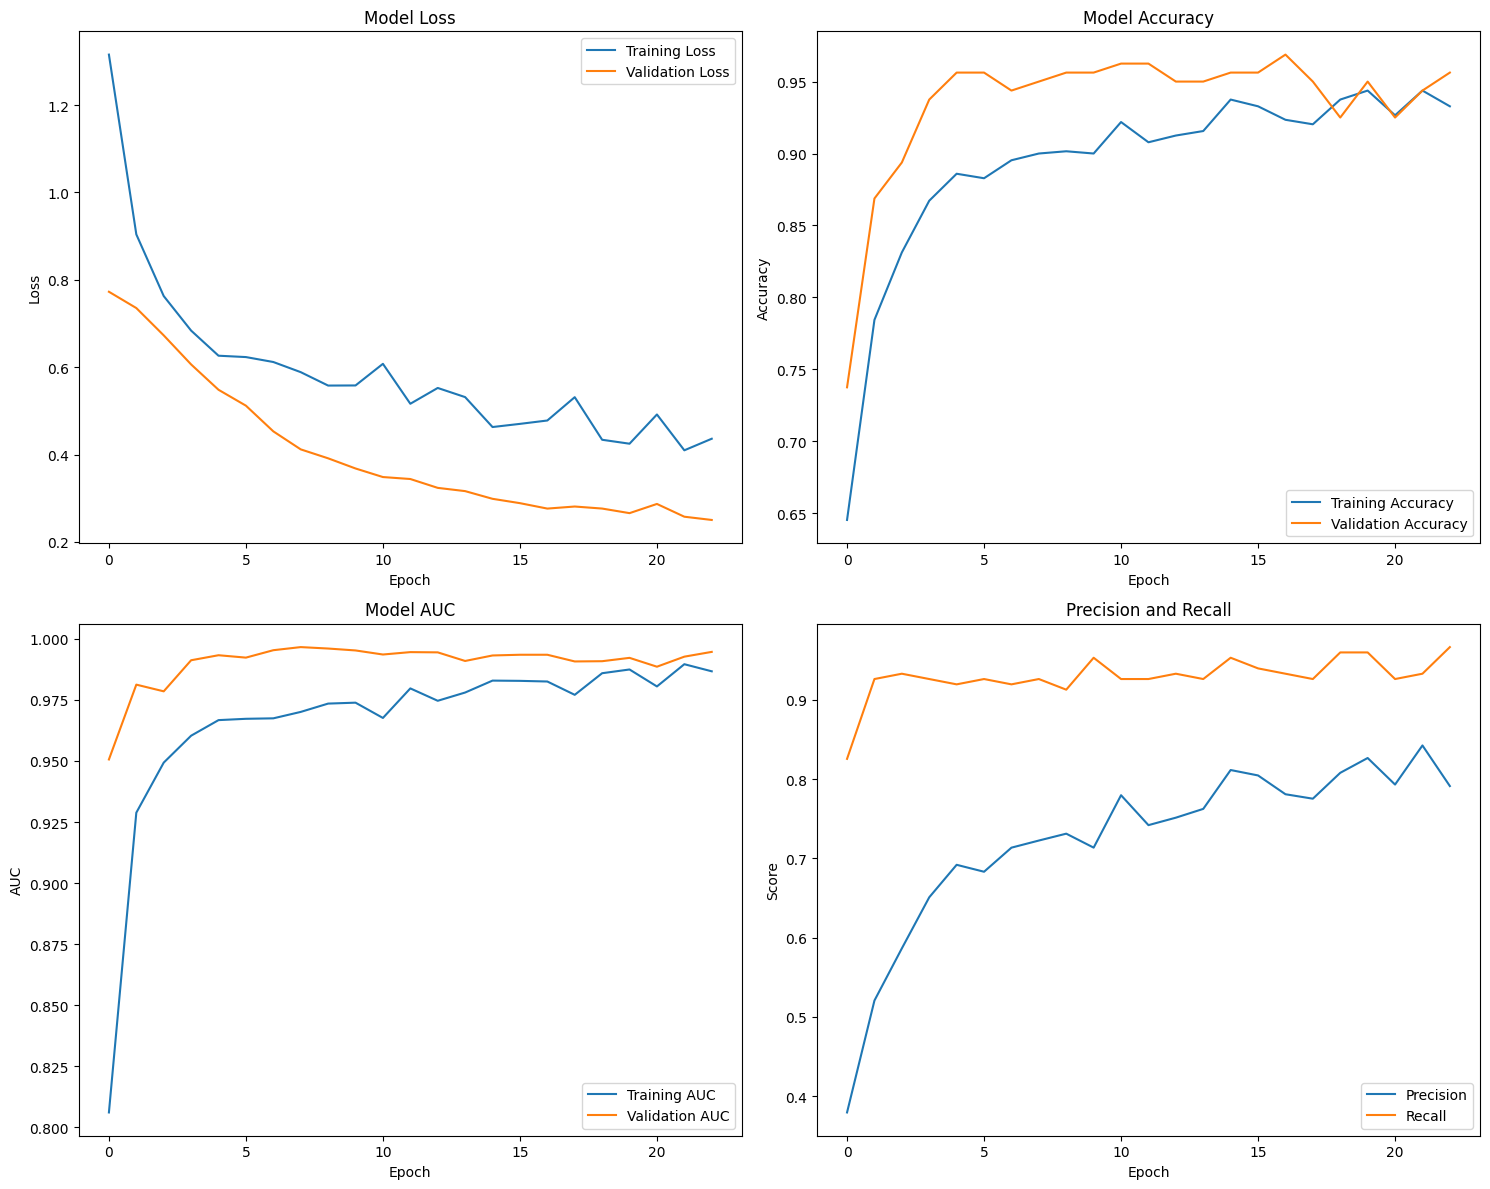

In [56]:
# Set up the visualization
plt.style.use('default')  # or 'classic'
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot training history
# Loss
axes[0,0].plot(history.history['loss'], label='Training Loss')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()

# Accuracy
axes[0,1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0,1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()

# AUC
axes[1,0].plot(history.history['auc'], label='Training AUC')
axes[1,0].plot(history.history['val_auc'], label='Validation AUC')
axes[1,0].set_title('Model AUC')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('AUC')
axes[1,0].legend()

# Precision-Recall
axes[1,1].plot(history.history['precision'], label='Precision')
axes[1,1].plot(history.history['recall'], label='Recall')
axes[1,1].set_title('Precision and Recall')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Score')
axes[1,1].legend()

plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       152
           1       0.88      0.94      0.91        48

    accuracy                           0.95       200
   macro avg       0.93      0.95      0.94       200
weighted avg       0.96      0.95      0.96       200



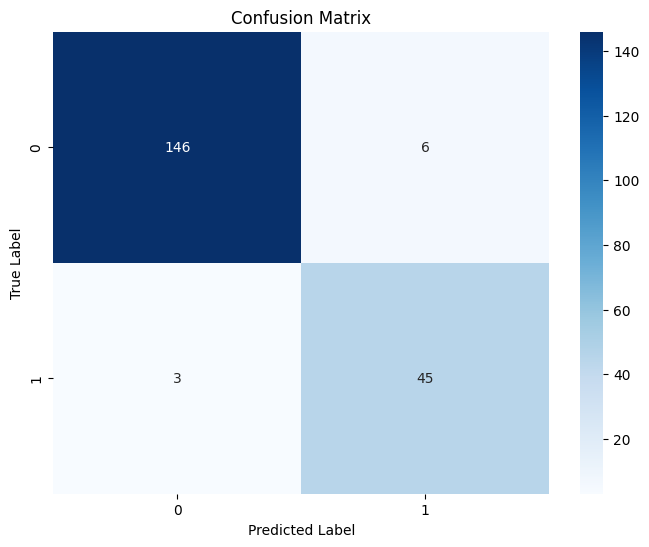

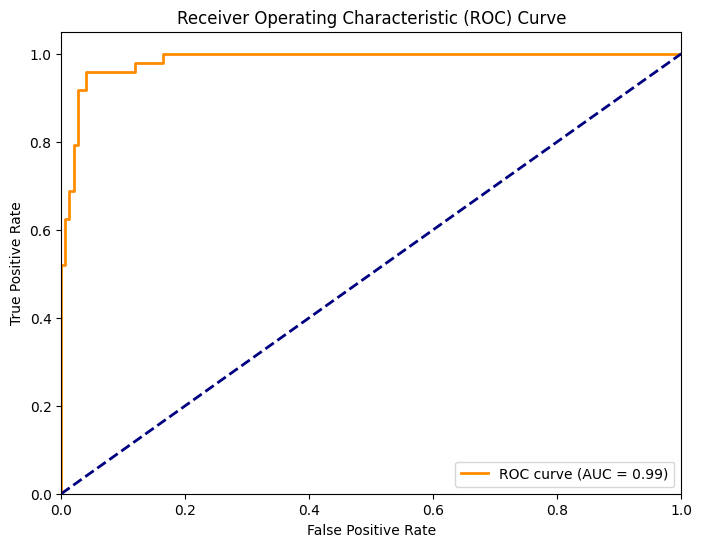

In [57]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

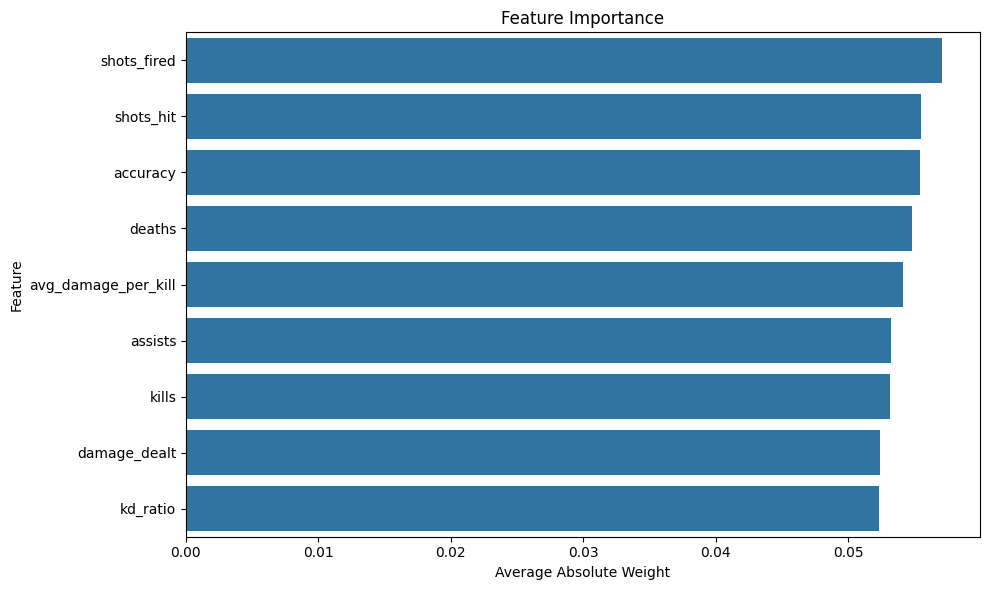

In [58]:
# Create feature importance visualization using model weights
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
feature_names = X_train.columns

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Average Absolute Weight')
plt.tight_layout()
plt.show()